In [0]:
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from fastprogress import progress_bar as pb

In [0]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(
        512, scale=(0.5, 1.0),
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    # transforms.Normalize((0.5, ), (0.5, ))
])
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    # transforms.Normalize((0.5, ), (0.5, ))
])
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=32,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=32,
                                            shuffle=False, 
                                            num_workers=2)

In [0]:
DEVICE = 'cuda'

class VariationalAutoEncoder2D(nn.Module):

    def __init__(
        self,
        input_dim: int=512,
        in_channels: int=3,
        out_channels: int=32,
        k_size: int=7,
        stride: int=3,
        z_dim: int=100,
        hidden_dim: int=1024,
        padding: int=1,
        device: str=DEVICE,
    ):
        super(VariationalAutoEncoder2D, self).__init__()

        self._in_dim = input_dim
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._k_size = k_size
        self._stride = stride
        self._z_dim = z_dim
        self._device = device

        self._encoder = nn.Sequential(
            nn.Conv2d(self._in_channels, self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(self._out_channels, 2*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(2*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(2*self._out_channels, 4*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(4*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(4*self._out_channels, 8*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(8*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(8*self._out_channels, 16*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(16*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
        )
        fc_layer_in_dim = self._get_fc_layer_in_dim()
        self._fc_mu = nn.Linear(fc_layer_in_dim, z_dim)
        self._fc_log_sigma_sq = nn.Linear(fc_layer_in_dim, z_dim)
        self._fc = nn.Linear(z_dim, hidden_dim)

        self._decorder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 8*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(8*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(8*self._out_channels, 4*self._out_channels, self._k_size+1, self._stride, padding, bias=False),
            nn.BatchNorm2d(4*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(4*self._out_channels, 2*self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(2*self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(2*self._out_channels, self._out_channels, self._k_size, self._stride, padding, bias=False),
            nn.BatchNorm2d(self._out_channels),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(self._out_channels, self._in_channels, self._k_size, self._stride, padding, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

    def encode(self, x):
        h = self._encoder(x)
        h = h.view(h.size(0), -1)
        mu = self._fc_mu(h)
        log_sigma_sq = self._fc_log_sigma_sq(h)
        z = self._sampling(mu, log_sigma_sq)
        z = self._fc(z)
        z = z.unsqueeze(-1).unsqueeze(-1)
        return z

    def decode(self, x):
        return self._decorder(x)

    def reduce(self, x):
        return self.encode(x).squeeze(-1)

    def _get_fc_layer_in_dim(self):
        dummy_data = torch.randn(3, self._in_channels, self._in_dim, self._in_dim)
        dummy_data = self._encoder(dummy_data)
        dummy_data = dummy_data.view(dummy_data.shape[0], -1)
        return dummy_data.shape[1]

    def _sampling(self, mu, log_sigma_sq):
        epsilon = torch.randn(mu.size()).float().to(self._device)
        sigma = torch.exp(log_sigma_sq / 2).to(self._device)
        return mu + sigma * epsilon

    def set_device(self, device):
        self._device = device

In [0]:
vae_model = VariationalAutoEncoder2D().to('cuda')

In [52]:
from torchsummary import summary
summary(vae_model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 170, 170]           4,704
       BatchNorm2d-2         [-1, 32, 170, 170]              64
         LeakyReLU-3         [-1, 32, 170, 170]               0
            Conv2d-4           [-1, 64, 56, 56]         100,352
       BatchNorm2d-5           [-1, 64, 56, 56]             128
         LeakyReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 18, 18]         401,408
       BatchNorm2d-8          [-1, 128, 18, 18]             256
         LeakyReLU-9          [-1, 128, 18, 18]               0
           Conv2d-10            [-1, 256, 5, 5]       1,605,632
      BatchNorm2d-11            [-1, 256, 5, 5]             512
        LeakyReLU-12            [-1, 256, 5, 5]               0
           Conv2d-13            [-1, 512, 1, 1]       6,422,528
      BatchNorm2d-14            [-1, 51

In [0]:
vae_model = VariationalAutoEncoder2D().to('cuda')

In [28]:
vae_model(torch.randn(10, 3, 512, 512).float().to('cuda')).shape

torch.Size([10, 3, 512, 512])

In [22]:
vae_model._encoder(torch.randn(4, 3, 512, 512).float().to('cuda')).shape

torch.Size([4, 512, 1, 1])

In [23]:
vae_model.encode(torch.randn(4, 3, 512, 512).float().to('cuda')).shape

torch.Size([4, 1024, 1, 1])

In [0]:
batch, labels = next(iter(testloader))

In [92]:
batch.shape

torch.Size([32, 3, 512, 512])

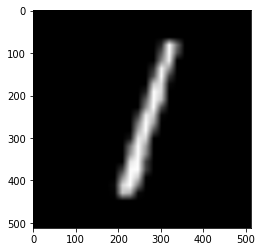

In [93]:
plt.imshow(batch[2, :, :, :].permute(1, 2, 0))

(array([642660.,   7749.,   7431.,   5166.,   4743.,   5295.,   4035.,
          3843.,   3744.,   3294.,   3525.,   2553.,   2886.,   2631.,
          2721.,   2523.,   2610.,   2610.,   2379.,   2532.,   2112.,
          2790.,   2493.,   2043.,   2895.,   2187.,   2874.,   2697.,
          2241.,   3141.,   2529.,   3339.,   4317.,   3711.,   4728.,
          4494.,   4683.,   6036.,   5631.,   6561.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ], dtype=float32),
 <a list of 40 Patch objects>)

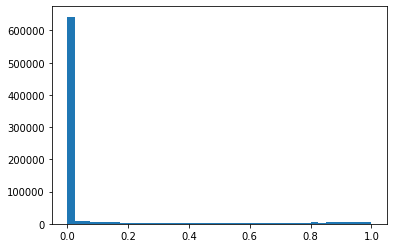

In [94]:
plt.hist(batch[0].flatten(), bins=40)

In [0]:
labels

tensor([0, 0, 1, 1, 1, 0, 1, 0])

In [0]:
ae_model = VariationalAutoEncoder2D().to('cuda')

In [0]:
_ = ae_model.train()

In [0]:
EPOCHS = 100

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_model.parameters(),
    lr=10e-3,
    weight_decay=1e-5
)

In [110]:
# 学習

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

ae_model.to('cuda')

for epoch in pb(range(EPOCHS)):
    print(epoch)

    # train

    ae_model.train()

    epoch_loss = 0.0
    epoch_corrects = 0

    for i, (batch, labels) in enumerate(pb(trainloader)):

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            preds = ae_model(batch.to('cuda')).cpu()
            loss = criterion(preds, batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.size(0)

        if i > 200:
            break
            
    if epoch % 2 == 0:
        for i in range(min(10, batch.shape[0])):
            plt.figure(figsize=(9,5))
            plt.subplot(1,3,1)
            plt.title('original train')
            plt.imshow(batch[i].permute(1, 2, 0))
            plt.subplot(1,3,2)
            plt.title('decoded train')
            plt.imshow(preds[i].detach().permute(1, 2, 0))
            plt.subplot(1,3,3)
            plt.title('diff train')
            plt.imshow((batch[i].permute(1, 2, 0)-preds[i].detach().permute(1, 2, 0)).abs())
            plt.show()
    
    epoch_loss = epoch_loss / len(trainloader.dataset)
    train_loss_history.append(epoch_loss)

    print('Train Loss : {:.4f}'.format(epoch_loss))

    # validation

    ae_model.eval()

    epoch_loss = 0.0
    epoch_corrects = 0

    for i, (batch, labels) in enumerate(pb(testloader)):

        with torch.set_grad_enabled(False):
            preds = ae_model(batch.to('cuda')).cpu()
            loss = criterion(preds, batch)

            epoch_loss += loss.item() * batch.size(0)

        if i > 100:
            break

    if epoch % 2 == 0:
        for i in range(min(10, batch.shape[0])):
            plt.figure(figsize=(9,5))
            plt.subplot(1,3,1)
            plt.title('original test')
            plt.imshow(batch[i].permute(1, 2, 0))
            plt.subplot(1,3,2)
            plt.title('decoded test')
            plt.imshow(preds[i].detach().permute(1, 2, 0))
            plt.subplot(1,3,3)
            plt.title('diff test')
            plt.imshow((batch[i].permute(1, 2, 0)-preds[i].detach().permute(1, 2, 0)).abs())
            plt.show()
    
    epoch_loss = epoch_loss / len(testloader.dataset)
    test_loss_history.append(epoch_loss)

    print('Test Loss : {:.4f}'.format(epoch_loss))

    print("="*100)

Output hidden; open in https://colab.research.google.com to view.

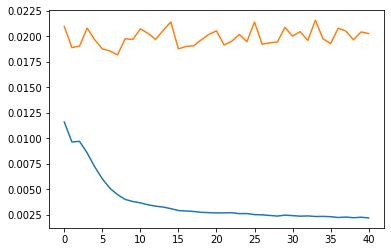

In [112]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

In [0]:
test_imgs = glob.glob('test/*')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


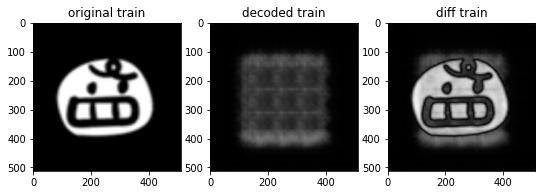

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


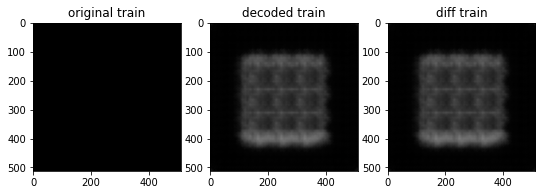

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


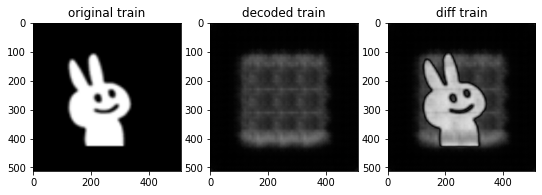

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


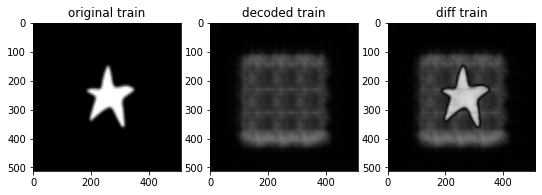

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


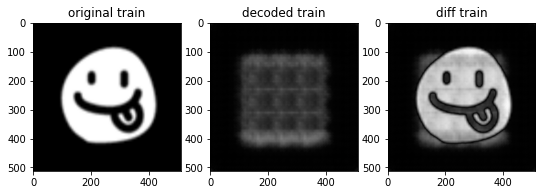

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


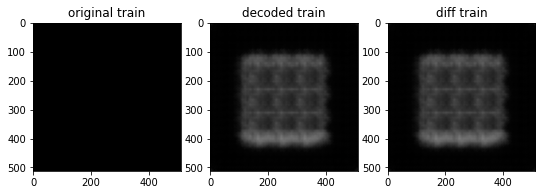

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


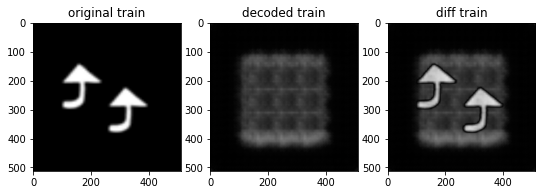

In [117]:
ae_model.eval()

for test_img in test_imgs:
    img = Image.open(test_img).convert('L')
    img_transformed = test_transform(img)
    print(img_transformed.shape)

    preds = ae_model(img_transformed.unsqueeze(0).to('cuda'))

    plt.figure(figsize=(9,5))
    plt.subplot(1,3,1)
    plt.title('original train')
    plt.imshow(img_transformed.permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.title('decoded train')
    plt.imshow(preds[0].detach().cpu().permute(1, 2, 0))
    plt.subplot(1,3,3)
    plt.title('diff train')
    plt.imshow((img_transformed.permute(1, 2, 0)-preds[0].detach().cpu().permute(1, 2, 0)).abs())
    plt.show()